### **Step 1: Import Libraries**
Start by importing the necessary libraries.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch
from sklearn.metrics import confusion_matrix, classification_report


2025-01-04 00:49:05.317974: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-04 00:49:05.320861: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-04 00:49:05.330424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735931945.346481   40647 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735931945.351148   40647 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-04 00:49:05.370247: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### **Step 2: Load and Preprocess the Data**
Download the breast cancer dataset and prepare it for training.

In [3]:
dataset_url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/breast-cancer.csv"
column_names = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
    "compactness_mean", "concavity_mean", "concave_points_mean", "symmetry_mean", "fractal_dimension_mean",
    "diagnosis"
]
data = pd.read_csv(dataset_url, names=column_names)
print(data.head())

  radius_mean texture_mean perimeter_mean area_mean smoothness_mean  \
0     '40-49'    'premeno'        '15-19'     '0-2'           'yes'   
1     '50-59'       'ge40'        '15-19'     '0-2'            'no'   
2     '50-59'       'ge40'        '35-39'     '0-2'            'no'   
3     '40-49'    'premeno'        '35-39'     '0-2'           'yes'   
4     '40-49'    'premeno'        '30-34'     '3-5'           'yes'   

  compactness_mean concavity_mean concave_points_mean symmetry_mean  \
0              '3'        'right'           'left_up'          'no'   
1              '1'        'right'           'central'          'no'   
2              '2'         'left'          'left_low'          'no'   
3              '3'        'right'          'left_low'         'yes'   
4              '2'         'left'          'right_up'          'no'   

   fractal_dimension_mean  diagnosis  
0     'recurrence-events'        NaN  
1  'no-recurrence-events'        NaN  
2     'recurrence-events'    

### **Step 3: Encode Non-Numeric Columns**


In [4]:
for col in data.columns:
    if data[col].dtype == 'object':
        print(f"Encoding non-numeric column: {col}")
        data[col] = LabelEncoder().fit_transform(data[col])


Encoding non-numeric column: radius_mean
Encoding non-numeric column: texture_mean
Encoding non-numeric column: perimeter_mean
Encoding non-numeric column: area_mean
Encoding non-numeric column: smoothness_mean
Encoding non-numeric column: compactness_mean
Encoding non-numeric column: concavity_mean
Encoding non-numeric column: concave_points_mean
Encoding non-numeric column: symmetry_mean
Encoding non-numeric column: fractal_dimension_mean


### **Step 4: Encode the Target Variable**


In [5]:
data['diagnosis'] = LabelEncoder().fit_transform(data['diagnosis'])


### **Step 5: Split Features and Target**


In [6]:
features = data.iloc[:, :-1]
target = data.iloc[:, -1]

scaler = StandardScaler()
features = scaler.fit_transform(features)


### **Step 6: Split the Dataset**
Split the dataset into training and testing set6.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


### **Step 7: Define a Hyperparameter Tuning Function**
Use Keras Tuner to define and tune hyperparameters.

In [8]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=8, max_value=64, step=8), activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i+2}', min_value=8, max_value=64, step=8), activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i+2}', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0001, 0.00001])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


### **Step 8: Perform Hyperparameter Tuning**
Search for the best hyperparameters using Keras Tuner.

In [9]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='tuner_results',
    project_name='breast_cancer_classification'
)

tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=16)


Reloading Tuner from tuner_results/breast_cancer_classification/tuner0.json


2025-01-04 00:49:16.701598: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### **Step 9: Retrieve Best Hyperparameters**


In [10]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best number of units: {best_hps.get('units_1')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")


Best number of units: 40
Best learning rate: 0.001


### **Step 10: Build and Train the Best Model**
Use the best hyperparameters for final training.

In [11]:
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=16)


Epoch 1/40


/home/akkey/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7054 - loss: 0.5699 - val_accuracy: 1.0000 - val_loss: 0.4125
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9076 - loss: 0.3855 - val_accuracy: 1.0000 - val_loss: 0.2839
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9569 - loss: 0.2850 - val_accuracy: 1.0000 - val_loss: 0.1923
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9541 - loss: 0.2217 - val_accuracy: 1.0000 - val_loss: 0.1288
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9809 - loss: 0.1517 - val_accuracy: 1.0000 - val_loss: 0.0876
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.1180 - val_accuracy: 1.0000 - val_loss: 0.0608
Epoch 7/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0840 - val_accuracy: 1.0000 - val_loss: 0.0420
Epoch 8/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0676 - val_accuracy: 1.0000 - val_loss: 0.0295
Ep

### **Step 11: Evaluate the Model**
Assess the model's performance on test data.

In [11]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.9606e-05
Test Accuracy: 1.00


### **Step 12: Perform Cross-Validation**
Validate the model's performance using Stratified K-Fold.

In [12]:
def cross_validate_model(X, y, model_builder, n_splits=5):
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for train_idx, test_idx in kfold.split(X, y):
        X_train_fold, X_test_fold = X[train_idx], X[test_idx]
        y_train_fold, y_test_fold = y[train_idx], y[test_idx]

        model = model_builder()
        model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=16, verbose=0)

        _, accuracy = model.evaluate(X_test_fold, y_test_fold, verbose=0)
        scores.append(accuracy)

    return np.array(scores)

def build_model_from_best_hps():
    return tuner.hypermodel.build(best_hps)

scores = cross_validate_model(features, target, build_model_from_best_hps)
print(f"Cross-Validation Accuracy: {scores.mean():.2f} ± {scores.std():.2f}")


/home/akkey/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/akkey/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/akkey/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regula

Cross-Validation Accuracy: 1.00 ± 0.00


### **Step 13: Visualize Training History**
Plot the training and validation accuracy.

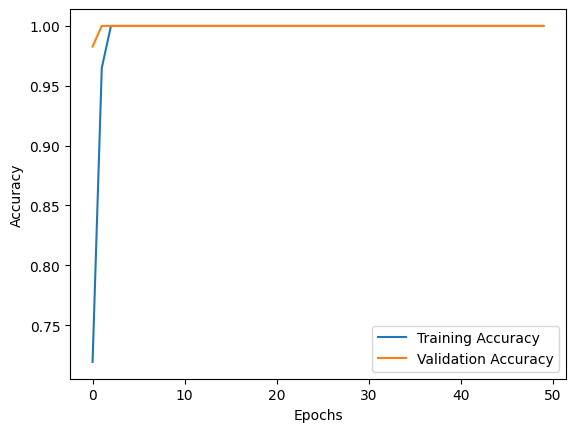

<Figure size 640x480 with 0 Axes>

In [13]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('/home/akkey/Code_chorni/Breast_cancer/training_validation_accuracy.png')


### **Step 14: Generate a Confusion Matrix**
Analyze predictions using a confusion matrix and classification report.

In [14]:
predictions = (best_model.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[58]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58

    accuracy                           1.00        58
   macro avg       1.00      1.00      1.00        58
weighted avg       1.00      1.00      1.00        58



/home/akkey/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
